In [7]:
import os, sys, email,re
import numpy as np 
from nltk.tokenize.regexp import RegexpTokenizer
from subprocess import check_output
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\01\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
import pandas as pd
emails_df = pd.read_csv('C:\\Users\\01\\Downloads\\emails.csv')
emails_df = emails_df.drop(emails_df.sample(n=467000).index)
emails_df = emails_df.reset_index(drop=True)
emails_df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/106.,Message-ID: <2707340.1075855687584.JavaMail.ev...
3,allen-p/_sent_mail/127.,Message-ID: <26911498.1075855688052.JavaMail.e...
4,allen-p/_sent_mail/131.,Message-ID: <32280829.1075855688139.JavaMail.e...


In [26]:
#функции для получения датасета в нормальном виде
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [27]:
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
emails_df['content'] = list(map(get_text_from_email, messages))
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df = emails_df[['user', 'content']]

In [28]:
def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent","aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())

    return normalized

In [29]:
>>> import nltk
>>> nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\01\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [30]:
from tqdm import tqdm

text_clean = []
for text in tqdm(emails_df['content']):
    text_clean.append(clean(text).split())

100%|██████████| 50401/50401 [00:46<00:00, 1074.13it/s]


In [31]:
emails_df['clean'] = text_clean

In [32]:
top_users = emails_df['user'].value_counts().head(20).index.tolist()
emails_df = emails_df[emails_df['user'].isin(top_users)]
emails_df=emails_df.drop('content', axis=1)

In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
emails_df['user'] = le.fit_transform(emails_df['user'])

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(emails_df['clean'], emails_df['user'], test_size=0.25, random_state=42, shuffle=True)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

X_train_w = [' '.join(words) for words in X_train]
X_test_w = [' '.join(words) for words in X_test]

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_w)
X_test = vectorizer.transform(X_test_w)

In [36]:
print(X_train.shape)
print(X_test.shape)

(20031, 84271)
(6678, 84271)


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sklearn.metrics as metrics

def batch_generator(X, Y, batch_size):
    size = len(X)
    indices = np.arange(size)
    np.random.shuffle(indices)
    for start in range(0, size, batch_size):
        end = min(start + batch_size, size)
        batch_idx = indices[start:end]
        yield X[batch_idx], Y[batch_idx]

In [38]:
import numpy as np
import torch
import scipy.sparse as sp

X_train = torch.FloatTensor(sp.csr_matrix(X_train).todense())
y_train = torch.LongTensor(np.array(y_train))
X_test = torch.FloatTensor(sp.csr_matrix(X_test).todense())
y_test = torch.LongTensor(np.array(y_test))

In [39]:
class FCModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128, dropout_rate=0.5):
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def fit(self, X, y, lr=0.01, epochs=100):
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = self(X)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()
        return self

    def accuracy(self, X, y):
        correct = 0
        total = 0
        with torch.no_grad():
            outputs = self(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
        return correct / total

In [40]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.relu(out)
        out = self.fc(out[:, -1, :])
        return out

In [41]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [42]:
input_size = X_train.shape[1]
hidden_size = 128
output_size = len(np.unique(y_train))

In [43]:
fc_model = FCModel(input_size, hidden_size, output_size)
rnn_model = RNNModel(input_size, hidden_size, output_size)
gru_model = GRUModel(input_size, hidden_size, output_size)

In [44]:
batch_size = 128
num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

In [110]:
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    for batch_x, batch_y in batch_generator(X_train, y_train, batch_size):
        optimizer.zero_grad()
        outputs = rnn_model(batch_x.view(-1, 1, input_size))
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

In [24]:
# Обучение GRU модели

optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    for batch_x, batch_y in batch_generator(X_train, y_train, batch_size):
        optimizer.zero_grad()
        outputs = gru_model(batch_x.view(-1, 1, input_size))
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

In [112]:
torch.save(fc_model.state_dict(), '2_fc_model_weights.pth')

In [113]:
torch.save(rnn_model.state_dict(), '2_rnn_model_weights.pth')

In [114]:
torch.save(gru_model.state_dict(), '2_gru_model_weights.pth')

In [48]:
from sklearn.metrics import accuracy_score

def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = accuracy_score(y.cpu().numpy(), predicted.cpu().numpy())
    return accuracy

In [46]:
def create_data_loader(X, y, batch_size):
    data = TensorDataset(torch.tensor(X), torch.tensor(y))
    return DataLoader(data, batch_size=batch_size)


In [43]:
def evaluate(model, criterion, data_loader):
    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.eval()

    with torch.no_grad():
        for x, y in data_loader:
            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item() * x.shape[0]
            total_correct += (torch.argmax(outputs, dim=1) == y).sum().item()
            total_samples += x.shape[0]

    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples

    return avg_loss, avg_accuracy

Epoch 1/10, train loss: 3.0508, train acc: 0.4341, val loss: 1.9132, val acc: 0.6563
Epoch 2/10, train loss: 1.4121, train acc: 0.7471, val loss: 1.3533, val acc: 0.7248
Epoch 3/10, train loss: 0.9352, train acc: 0.8157, val loss: 1.1762, val acc: 0.7432
Epoch 4/10, train loss: 0.6963, train acc: 0.8597, val loss: 1.1179, val acc: 0.7535
Epoch 5/10, train loss: 0.5595, train acc: 0.8860, val loss: 1.1312, val acc: 0.7514
Epoch 6/10, train loss: 0.4788, train acc: 0.9014, val loss: 1.1519, val acc: 0.7595
Epoch 7/10, train loss: 0.4067, train acc: 0.9171, val loss: 1.1477, val acc: 0.7583
Epoch 8/10, train loss: 0.3659, train acc: 0.9248, val loss: 1.2121, val acc: 0.7574
Epoch 9/10, train loss: 0.3299, train acc: 0.9326, val loss: 1.2397, val acc: 0.7574
Epoch 10/10, train loss: 0.3097, train acc: 0.9391, val loss: 1.6480, val acc: 0.7363


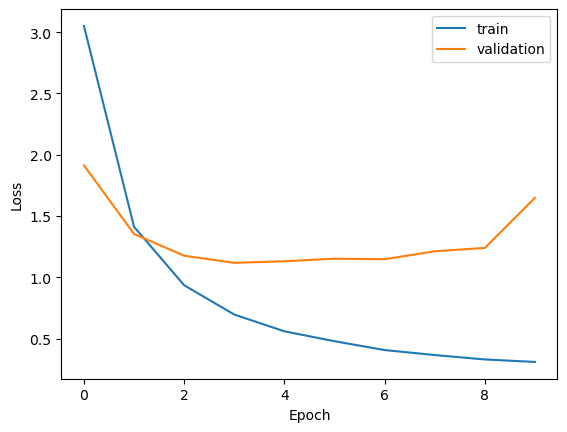

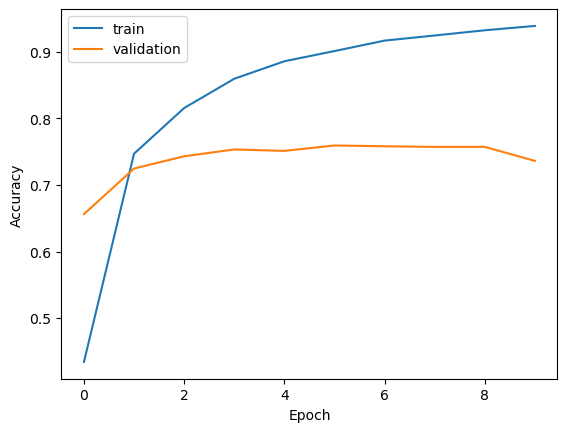

In [97]:
import matplotlib.pyplot as plt

X_val = torch.Tensor(X_test).float()
y_val = torch.Tensor(y_test).long()


optimizer = optim.Adam(fc_model.parameters(), lr=learning_rate)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for batch_x, batch_y in batch_generator(X_train, y_train, batch_size):
        optimizer.zero_grad()
        outputs = fc_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
        _, predicted = torch.max(outputs.data, 1)
        running_acc += (predicted == batch_y).sum().item()
    epoch_loss = running_loss / len(X_train)
    epoch_acc = running_acc / len(X_train)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for batch_x, batch_y in batch_generator(X_val, y_val, batch_size):
            outputs = fc_model(batch_x)
            loss = criterion(outputs, batch_y)
            running_loss += loss.item() * batch_x.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_acc += (predicted == batch_y).sum().item()
        epoch_loss = running_loss / len(X_val)
        epoch_acc = running_acc / len(X_val)
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, train loss: {train_losses[-1]:.4f}, train acc: {train_accs[-1]:.4f}, val loss: {val_losses[-1]:.4f}, val acc: {val_accs[-1]:.4f}')


plt.plot(range(num_epochs), train_losses, label='train')
plt.plot(range(num_epochs), val_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(range(num_epochs), train_accs, label='train')
plt.plot(range(num_epochs), val_accs, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [111]:
rnn_model.eval()

with torch.no_grad():
    y_pred = []
    for batch_x, batch_y in batch_generator(X_test, y_test, batch_size):
        outputs = rnn_model(batch_x.view(-1, 1, input_size))
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())

rnn_accuracy = accuracy_score(y_test, y_pred)
print("RNN accuracy score: {:.2f}%".format(rnn_accuracy * 100))

RNN accuracy score: 6.97%


In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

rnn_model.eval()

with torch.no_grad():
    y_pred = []
    for batch_x, batch_y in batch_generator(X_test, y_test, batch_size):
        outputs = rnn_model(batch_x.view(-1, 1, input_size))
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())

rnn_precision = precision_score(y_test, y_pred, average='weighted')
rnn_recall = recall_score(y_test, y_pred, average='weighted')
rnn_f1 = f1_score(y_test, y_pred, average='weighted')

print("RNN precision score: {:.2f}%".format(rnn_precision * 100))
print("RNN recall score: {:.2f}%".format(rnn_recall * 100))
print("RNN F1 score: {:.2f}%".format(rnn_f1 * 100))

RNN precision score: 6.17%
RNN recall score: 6.29%
RNN F1 score: 6.23%


In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

gru_model.eval()

with torch.no_grad():
    y_pred = []
    for batch_x, batch_y in batch_generator(X_test, y_test, batch_size):
        outputs = gru_model(batch_x.view(-1, 1, input_size))
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())

        
# Вычисление метрик precision, recall и f1-score
gru_precision = precision_score(y_test, y_pred, average='weighted')
gru_recall = recall_score(y_test, y_pred, average='weighted')
gru_f1 = f1_score(y_test, y_pred, average='weighted')

print("GRU precision score: {:.2f}%".format(gru_precision * 100))
print("GRU recall score: {:.2f}%".format(gru_recall * 100))
print("GRU F1 score: {:.2f}%".format(gru_f1 * 100))

GRU precision score: 6.22%
GRU recall score: 6.37%
GRU F1 score: 6.28%


In [52]:
gru_model.eval()

with torch.no_grad():
    y_pred = []
    for batch_x, batch_y in batch_generator(X_test, y_test, batch_size):
        outputs = gru_model(batch_x.view(-1, 1, input_size))
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())

gru_accuracy = accuracy_score(y_test, y_pred)
print("GRU accuracy score: {:.2f}%".format(gru_accuracy * 100))

GRU accuracy score: 6.52%
